In [1]:
import pandas as pd
import numpy as np
import math
import time
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score, rand_score, accuracy_score, precision_score, f1_score, adjusted_rand_score
from tribus import marker_expression
from minisom import MiniSom
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch

# Define the functions used in this notebook

In [22]:
def train_som(x, y, input_len, sigma, learning_rate, iterations): 
    # a function to call minisom easily.

    som = MiniSom(x=x, 
                  y=y, 
                  input_len = input_len, 
                  sigma = sigma, 
                  learning_rate = learning_rate, 
                  neighborhood_function='gaussian')
    som.random_weights_init(marker_data)
    # training
    start_time = time.time()
    som.train_random(marker_data, iterations)
    elapsed_time = time.time() - start_time
    print(elapsed_time, " seconds")
    return som

def cell_num_compare(true_label, pred_label): 
    # Plot barplots that show cell numbers in each type, compare with ground truth. 

    Tribus_stat = pd.DataFrame(np.array(np.unique(pred_label, return_counts=True)).T, columns=("Cell_type", "Tribus"))
    Truth_stat = pd.DataFrame(np.array(np.unique(true_label, return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
    Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
    Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
    Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

    Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)
    plt.show()


def get_subsets(sample_file, labels):
    # copied from Tribus. 

    cell_types = np.unique(labels)
    new_file = sample_file.copy()
    new_file.loc[:, 'labels'] = labels
    subsets = []
    normal_cell_types = []
    for cell_type in cell_types:
        if "undefined" in cell_type or "other" in cell_type:
            continue
        else:
            subsets.append(new_file.loc[new_file['labels'] == cell_type])
            normal_cell_types.append(cell_type)
    return subsets, normal_cell_types

def my_confusion_matrix(true_label, pred_label): 
    # Plot confusion matrix. 

    celltype_true = np.array(true_label).tolist()
    celltype_pred = np.array(pred_label).tolist()
    cm_labels = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def cluster_metrics_overall(celltype_true, celltype_pred): 
    # Calculate average accuracy metrics and visualization with barplot

    RI_avg = rand_score(celltype_true, celltype_pred) #between 0-1
    AS_avg = accuracy_score(celltype_true, celltype_pred)
    PS_avg = precision_score(celltype_true, celltype_pred, average='weighted')
    F1_avg = f1_score(celltype_true, celltype_pred, average="weighted")
    print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
    df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], 
                    index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])

    colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
    df.plot.bar(y='Value', width = 0.8, legend=False, 
                color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
    metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

def cluster_metrics_percelltype(celltype_true, celltype_pred): 
    # accuracy metrics per cell type

    classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
    stats_df = pd.DataFrame()
    for i in range(len(stats_array)):
        stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
    stats_df.columns = ["TN", "FP", "FN", "TP"]
    stats_df.index = [classes]
    stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
    print(stats_df)
    report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Support is the number of actual occurrences of the class in the specified dataset.
    rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 4)
    fig, ax = plt.subplots(rows, 4, figsize=(15,7))

    for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
        
        celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
        df = report_df.loc[celltype]
        df["accuracy"] = stats_df.iloc[i,-1].tolist()
        df = df[["precision", "recall", "f1-score", "accuracy"]]
        
        colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
        df.plot.bar(y='Value', ax=ax[int(i / 4)][i % 4], width = 0.85, 
                    title="{}".format(celltype), legend=False, 
                    color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

    metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

# Read in datasets

3 datasets was included in this analysis. 

- CODEX: published Co-detection by indexing (CODEX) imaging dataset collected from the healthy human colon (N = 110633 cells)
- CyTOF: published multiplexed ion beam imaging by time-of-flight (MIBI-TOF) dataset (N = 197678 cells) consisting of tissues from 41 triple-negative breast cancer patients.
- TMA: published tumor tissue microarray (TMA) dataset including a total of 112 cores from 44 high-grade serous ovarian cancers (HGSCs)

For Pre-processing: Keep it as simple as possible in order to see how minisom performs in complex datasets. 

- Remove outliers with 99.9 percentile. 
- No normalization was performed. 
- Currently, No cores in TMA were removed. 

In [14]:
data_type = "CyTOF"
Q = 0.999
Logic = False # True means only use the markers include in logic table

In [15]:
if data_type == "CODEX": 

    # read in CODEX donor 004 cl dataset
    sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
        'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
        'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
        'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
        'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
        'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
        'Ki67', 'CD49a', 'CD163', 'CD161']

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl_benchmarking.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)

    celltype1 = "cell_type_A"
    celltype2 = "cell_type_upperlevel"

elif data_type == "TMA": 

    # read input files
    # no outlier filtering
    sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\TMA_works\\TMA_all_data_labeled.csv")
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ['CD11c', 'CD1c', 'CD4', 'CD3d', 'CD20', 'CD163',
        'CD8a', 'cCasp3', 'pSTAT1', 'Ki67', 'PDL1', 'IBA1', 'FOXP3', 'PD1',
        'Ecadherin', 'vimentin', 'CD31', 'P21', 'CK7', 'CD45',"Eccentricity"]
    
    celltype1 = "CellType"
    celltype2 = "merged_labels"

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\TMA_works\\cell_type_descriptions.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)
    
elif data_type == "CyTOF": 

    # read input files
    # no outlier filtering
    sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data_origin.csv")
    print("Data dimension is {}".format(np.shape(sample_data)))

    #  perform always outlier truncation, set the maximum to the 99。9 percentile
    cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
            'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
            'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
            'CD163','CD68', 'CD8', 'CD3', 'IDO', 
            'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
            'Beta catenin', 'HLA-DR', 'CD11b', 'CD45',
            'Pan-Keratin', 'MPO','Keratin6']
    
    celltype1 = "DetailedGroup"
    celltype2 = "DetailedGroup"

    df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\logic_gate.xlsx")
    logic = pd.read_excel(df, df.sheet_names, index_col=0)
    markers = list(logic["Global"].index)

Q = sample_data[cols].quantile(Q)
sample_data = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print("Removing the outliers. Curent data dimension is {}".format(np.shape(sample_data)))
sample_data[cols].describe()

labels_true_1 = sample_data[celltype1]
print("Cell types in detailed is {}".format(np.unique(labels_true_1)))
labels_true_2 = sample_data[celltype2]
print("Cell types merged (optional) is {}".format(np.unique(labels_true_2)))

grid_size = int(np.sqrt(np.sqrt(len(sample_data)) * 5))
print("Current dataset is {}".format(data_type))
print("The grid size for miniSOM is {}".format(grid_size))

if logic == "FALSE":    
    marker_data = np.arcsinh(sample_data[cols]).to_numpy()
else: 
    marker_data = np.arcsinh(sample_data[markers]).to_numpy()


Data dimension is (197678, 59)
Removing the outliers. Curent data dimension is (192064, 59)
Cell types in detailed is ['B' 'CD3 T' 'CD4 T' 'CD8 T' 'DC' 'DC/Mono' 'Endothelial' 'Immune'
 'Keratin-positive tumor' 'Macrophages' 'Mesenchymal-like' 'Mono/Neu' 'NK'
 'Neutrophils' 'Other immune' 'Tumor' 'Unidentified']
Cell types merged (optional) is ['B' 'CD3 T' 'CD4 T' 'CD8 T' 'DC' 'DC/Mono' 'Endothelial' 'Immune'
 'Keratin-positive tumor' 'Macrophages' 'Mesenchymal-like' 'Mono/Neu' 'NK'
 'Neutrophils' 'Other immune' 'Tumor' 'Unidentified']
Current dataset is CyTOF
The grid size for miniSOM is 46


In [5]:
# Initialization and training
som_shape = (grid_size, grid_size)
som = MiniSom(som_shape[0], som_shape[1], marker_data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian')

som.train_batch(marker_data, 500, verbose=True)
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in marker_data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
print("Number of clusters generated: {}".format(len(np.unique(cluster_index))))
# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
print("Homogeneity score calculated with detailed cell types: {}". format(homogeneity_score(labels_true_1, cluster_index)))
print("Homogeneity score calculated with merged cell types: {}". format(homogeneity_score(labels_true_2, cluster_index)))
print("Completeness score calculated with detailed cell types: {}". format(completeness_score(labels_true_1, cluster_index)))
print("Completeness score calculated with merged cell types: {}". format(completeness_score(labels_true_2, cluster_index)))

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.114202554245206
Number of clusters generated: 1296
Homogeneity score calculated with detailed cell types: 0.6244663134245971
Homogeneity score calculated with merged cell types: 0.6244663134245971
Completeness score calculated with detailed cell types: 0.27806858041816473
Completeness score calculated with merged cell types: 0.27806858041816473


# Hyperparameter tuning

In [6]:
# set hyperparameters
rows_data = marker_data.shape[0]
x = int(np.sqrt(5 * np.sqrt(rows_data)))
print("x is {}".format(x))
y = x
input_len = marker_data.shape[1]
sigma = 0.003
learning_rate = 5
iterations = 100

space = {
    'sig': hp.uniform("sig", 0.001, 5), 
    'learning_rate': hp.uniform("learning_rate", 0.001, 5),
}

def som_fn(space): 
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x, 
                  y=x, 
                  input_len=input_len,
                  sigma=sig,
                  learning_rate=learning_rate
                  ).quantization_error(marker_data)
    print("Current quantization error is {}".format(val))
    return{'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn = som_fn, 
            space=space, 
            algo = tpe.suggest, 
            max_evals=15, 
            trials=trials)

print('best: {}'.format(best))

# for i, trial in enumerate(trials.trials[:2]): 
#     print(i, trials)

x is 46
Current quantization error is 1.2730698347179836      
Current quantization error is 1.2627622918954635                                
Current quantization error is 1.2822398693610366                                
Current quantization error is 1.2801787604855925                                
Current quantization error is 1.251560970988144                                 
Current quantization error is 1.2564908445737808                                
Current quantization error is 1.2723738740431172                               
Current quantization error is 1.286521998477845                                
Current quantization error is 1.2775266181493476                               
Current quantization error is 1.2849575808973221                               
Current quantization error is 1.2753506701474961                                
Current quantization error is 1.2949705071936568                                
Current quantization error is 1.2574457537959745  

In [7]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("Current grid size x is {}, grid size y is {}, sigma is {}, learning rate is {}.".format(x, y, sigma, learning_rate))

Current grid size x is 46, grid size y is 46, sigma is 3.373490290137513, learning rate is 4.839394885940137.


In [8]:
som = MiniSom(x, y, input_len, sigma=sigma, learning_rate=learning_rate,
              neighborhood_function='gaussian')

som.train_batch(marker_data, 500, verbose=True)

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in marker_data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
som_shape = (grid_size, grid_size)
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

print("Number of clusters generated: {}".format(len(np.unique(cluster_index))))

# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
print("Homogeneity score calculated with detailed cell types: {}". format(homogeneity_score(labels_true_1, cluster_index)))
print("Homogeneity score calculated with merged cell types: {}". format(homogeneity_score(labels_true_2, cluster_index)))
print("Completeness score calculated with detailed cell types: {}". format(completeness_score(labels_true_1, cluster_index)))
print("Completeness score calculated with merged cell types: {}". format(completeness_score(labels_true_2, cluster_index)))


 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.0153746956052865
Number of clusters generated: 1874
Homogeneity score calculated with detailed cell types: 0.6509846041204969
Homogeneity score calculated with merged cell types: 0.6509846041204969
Completeness score calculated with detailed cell types: 0.25120391866963426
Completeness score calculated with merged cell types: 0.25120391866963426


# Check the initial clusters

In this part I'm aiming to check whether miniSOM can successfully clustered same cell types together. 
1. Calculate the counts of cells in each cell type per cluster.
2. Extract the cell type that dominant the cluster (the one that has largest counts)
3. The cluster will be annotated by the corresponding cell type. 
4. Visualize the result.

In [9]:
# getting cell types

d = {'real': np.array(labels_true_2), 'pred': cluster_index}
df = pd.DataFrame(data = d)

pd.options.display.max_rows = 100
df_count = df.groupby(["pred", "real"]).size().reset_index(name='counts')
df_assign = df_count.groupby('pred').apply(lambda x: x.real[x.counts.idxmax()])
dict_replace = df_assign.to_dict()

# Define a function that takes an element and returns its replacement
def replace(element):
    return dict_replace.get(element, element)
# Vectorize the function
vfunc = np.vectorize(replace)
# Apply the function to our array
labels_df = vfunc(cluster_index)

labels_df = pd.DataFrame(labels_df)
labels_df.columns = ["Global"]

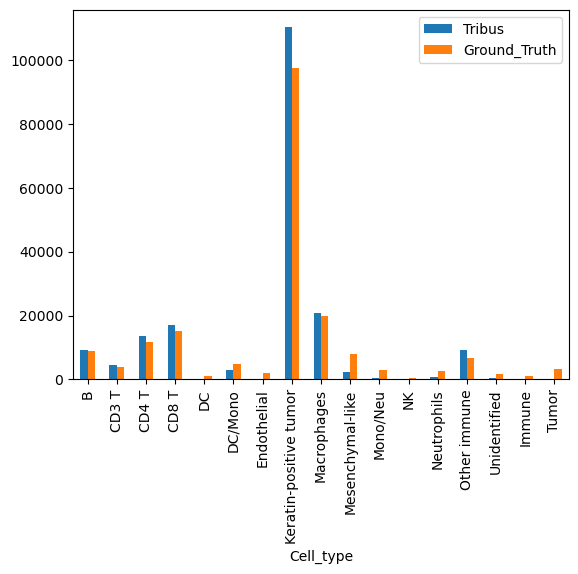

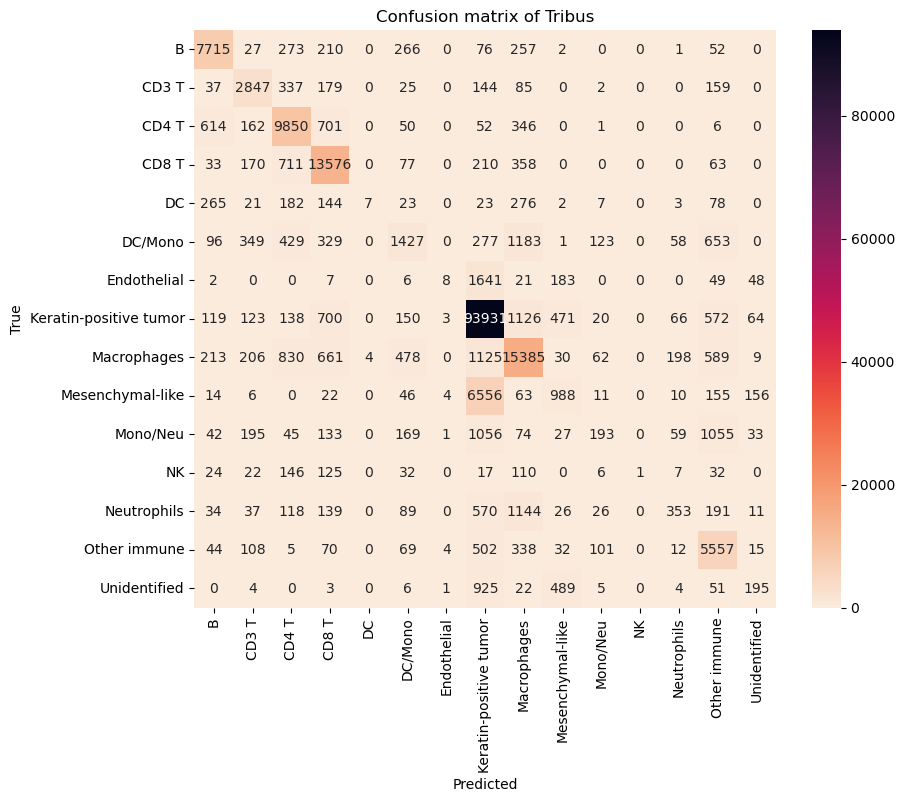

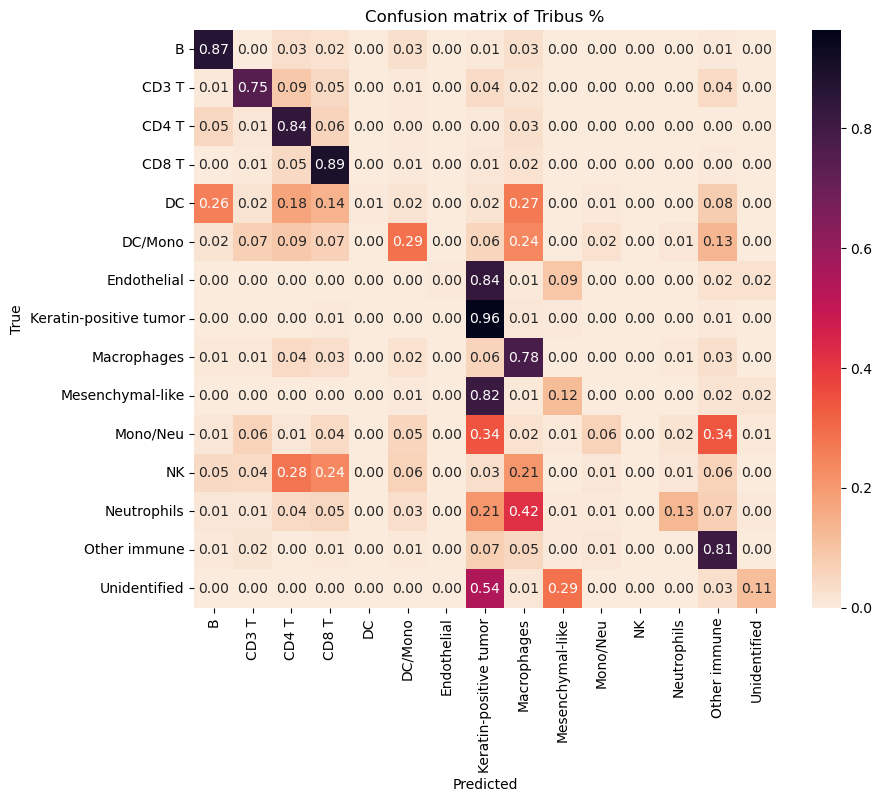

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.8700632798092987, Accuracy score = 0.7915746834388537, Precision score = 0.7435477444509031, F1 score = 0.7520109914888568


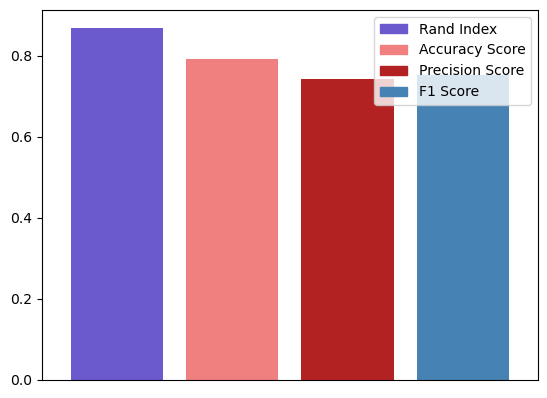

                            TN     FP    FN     TP  accuracy
B                       181632   1553  1164   7715  0.985854
CD3 T                   186661   1588   968   2847  0.986692
CD4 T                   176509   3773  1932   9850  0.970296
CD8 T                   173317   3549  1622  13576  0.973077
DC                      191029      4  1024      7  0.994648
DC/Mono                 185643   1496  3498   1427  0.973998
Endothelial             190085     14  1957      8  0.989738
Keratin-positive tumor   78196  16385  3552  93931  0.896196
Macrophages             166767   5507  4405  15385  0.948392
Mesenchymal-like        182753   1280  7043    988  0.956665
Mono/Neu                188618    364  2889    193  0.983063
NK                      191542      0   521      1  0.997287
Neutrophils             188903    423  2385    353  0.985380
Other immune            181450   3757  1300   5557  0.973670
Unidentified            190021    338  1510    195  0.990378
                        

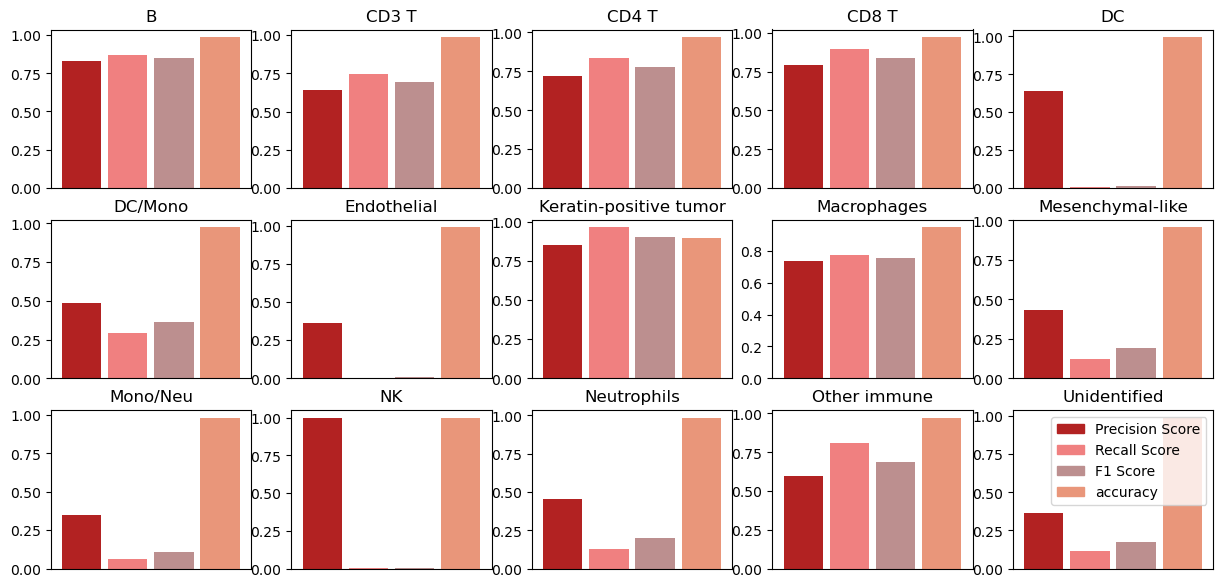

KeyError: 'DC'

In [16]:
# visualize

cell_num_compare(labels_true_2, labels_df["Global"])
my_confusion_matrix(labels_true_2, labels_df["Global"])
cluster_metrics_overall(labels_true_2, labels_df["Global"])
cluster_metrics_percelltype(labels_true_2, labels_df["Global"])

c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3)
level = "Global"
cmap_='vlag'
dendrogram_ratio_=0.1
title=""

df_median = pd.DataFrame()
df_annotation_table = pd.DataFrame()
markers = list(logic[level].index)
filtered_sample = sample_data[markers]
filtered_labels = labels_df[level][labels_df[level].notnull()]
description_table = logic[level]
values = [-1, 0, 1]
tables, cell_types = get_subsets(filtered_sample, filtered_labels)

for i in range(len(cell_types)):
    df_median[cell_types[i]] = tables[i].iloc[:, :-1].median()
    new_value = description_table[cell_types[i]]
    palette_ = c_palette
    lut = dict(zip(values, palette_))
    row_colors = new_value.map(lut)
    df_annotation_table[cell_types[i]] = list(row_colors)

df_annotation_table = df_annotation_table.set_index(df_median.index)
df_median = z_score(df_median.transpose())
sns.clustermap(df_median.replace(np.nan,0), figsize=(8, 6), cmap=cmap_, col_colors=df_annotation_table,
                dendrogram_ratio=dendrogram_ratio_, colors_ratio=0.02).fig.suptitle(title, fontweight="bold", y=1.01)
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Expected values', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure,
            loc='upper right')
plt.show()


# Write scoring function demo

In this part I extract the scoring function in Tribus and use it to annotate minisom result. 

In [17]:
# All cpoied from Tribus. 

def score_marker_pos(x):
    """
    get the largest value for a marker, subtract from it all the values --> take the squared
    large values will get small values, small values get larger values
    """
    res = [(np.percentile(x, MAX_PERCENTILE) - i) ** 2 for i in x]
    return res


def score_marker_neg(x):
    """
    substrach the minimum from each value --> take the squared
    large values remain large, small values became smaller
    """
    res = [(i - np.min(x)) ** 2 for i in x]
    return res


def normalize_scores(x):
    """
    normalize the values between 0-1
    change the direction of scoring, smaller ones becomes the larger ones and vica versa (inverting)
    """
    if np.max(x) - np.min(x) == 0:
        print(x)

    res = 1 - ((x - np.min(x)) / (np.max(x) - np.min(x)))
    return res


def score_nodes(data_to_score, logic, level):
    """
    scoring function for the clusters, which cluster belong to which cell-type
    data_to_score: dataframe
    logic: dictionary of dataframes
    level: string
    returns: dataframe
    """
    level_logic_df = logic[level]
    scores_matrix = np.zeros((data_to_score.shape[0], logic[level].shape[1]))
    for idx, cell_type in enumerate(logic[level].columns.values):
        list_negative = list(
            level_logic_df.loc[level_logic_df[cell_type] == -1].index)  # get markers with negative scores
        list_positive = list(
            level_logic_df.loc[level_logic_df[cell_type] == 1].index)  # get markers with positive scores

        if list_positive == 0:
            continue

        gating_positive = data_to_score[list_positive].to_numpy()  # rows: clusters, columns: positive markers
        marker_scores_positive = np.apply_along_axis(score_marker_pos, 0, gating_positive)

        if len(list_negative) != 0:
            gating_negative = data_to_score[list_negative].to_numpy()
            marker_scores_negative = np.apply_along_axis(score_marker_neg, 0, gating_negative)

            marker_scores = np.column_stack((marker_scores_positive, marker_scores_negative))
        else:
            marker_scores = marker_scores_positive

        normalized_marker_scores = np.apply_along_axis(normalize_scores, 0, marker_scores)
        scores_matrix[:, idx] = np.mean(normalized_marker_scores, 1) # put the mean of the marker values of a celltype into a matrix (indexed by the celltypes)
    scores_pd = pd.DataFrame(scores_matrix, columns=logic[level].columns.values, index=data_to_score.index)
    return scores_pd

def get_cell_type(x, level, undefined_threshold, other_threshold):
    '''
    assigning cell type based on the score, write "other" if highest score is too low, write "undifined" if the two highest score are too close to eachother
    '''
    sorted_ = np.sort(x)
    highest = sorted_[-1]
    second_highest = sorted_[-2]
    if highest < other_threshold:
        return f'other_{level}'
    if highest-second_highest < undefined_threshold:
        return f'undefined_{level}'
    return x.idxmax()

def get_probabilities(x):
    '''
    assigning the highest probability to each cell
    '''
    return np.max(x)

In [18]:
level = "Global"
labeled = sample_data[logic[level].index.values].copy()
labeled['label'] = cluster_index
data_to_score = labeled.groupby('label').median()

MAX_PERCENTILE = 99
scores_pd = score_nodes(data_to_score, logic, "Global")

In [19]:
# assign highest scored label
undefined_threshold=0.001
other_threshold=0.4

scores_labels = pd.DataFrame()
scores_labels['cell_label'] = scores_pd.apply(lambda x: get_cell_type(x, level, undefined_threshold, other_threshold), axis=1)
scores_labels['probability'] = scores_pd.apply(get_probabilities, axis=1)
labels_list = scores_labels.loc[labeled['label']].cell_label # according to the cluster labels, assign the most probable cell-type to each cell
prob_list = scores_labels.loc[labeled['label']].probability
labels_df = pd.DataFrame(labels_list)
labels_df = labels_df.set_index(labeled.index)
prob_df = pd.DataFrame(prob_list)
prob_df = prob_df.set_index(labeled.index)
labels_df = labels_df.rename(columns={'cell_label': level})
prob_df = prob_df.rename(columns={'probability': level})

# Visualize the result

Text(0.5, 1.0, 'Distributions of node probability')

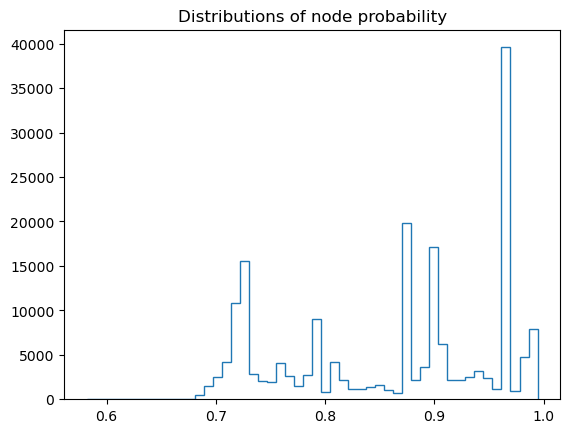

In [20]:
hist, edges = np.histogram(prob_df, bins=50)
plt.stairs(hist, edges)
plt.title("Distributions of node probability")

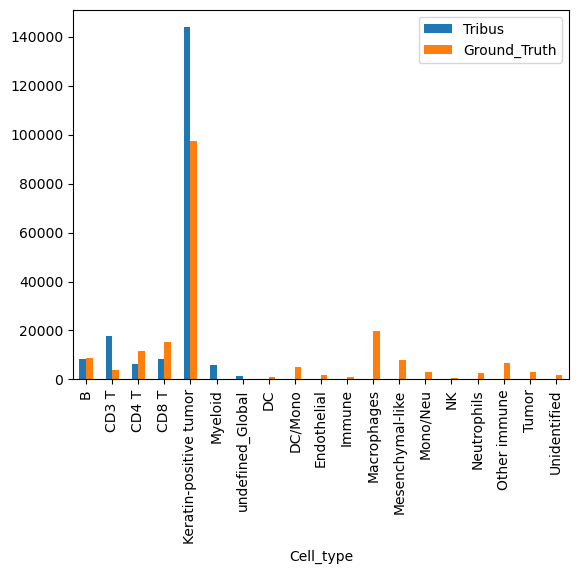

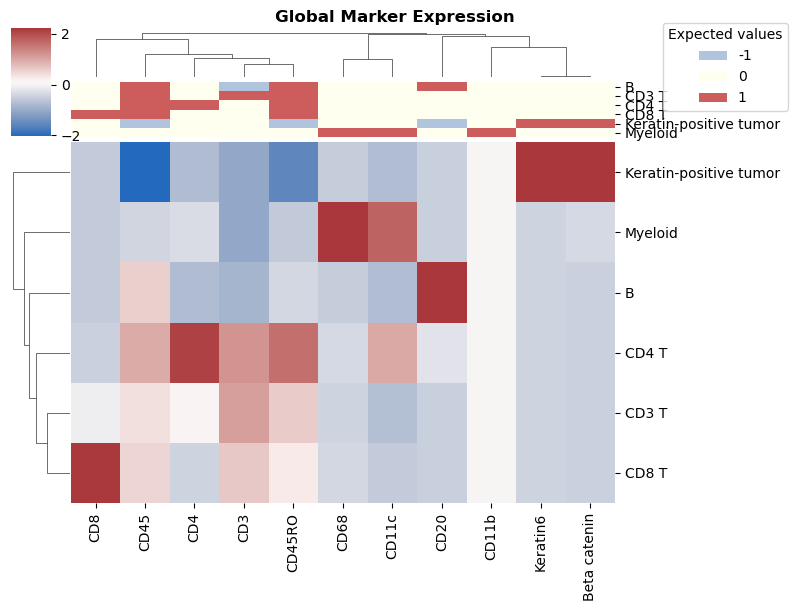

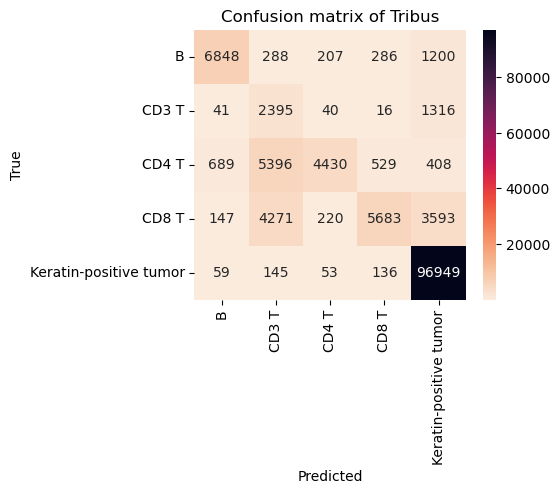

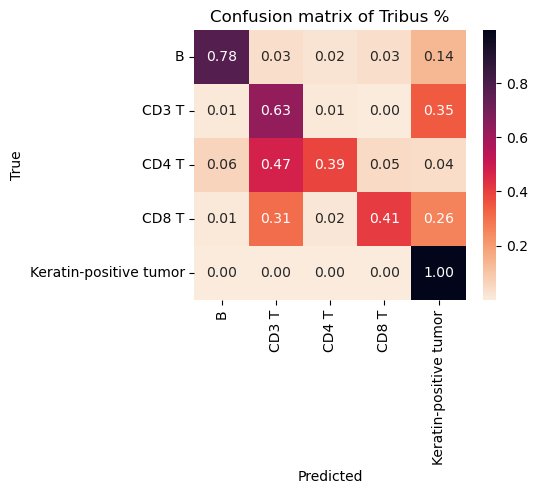

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.6745505762521903, Accuracy score = 0.605553357214262, Precision score = 0.48009869777924014, F1 score = 0.5173109160576252


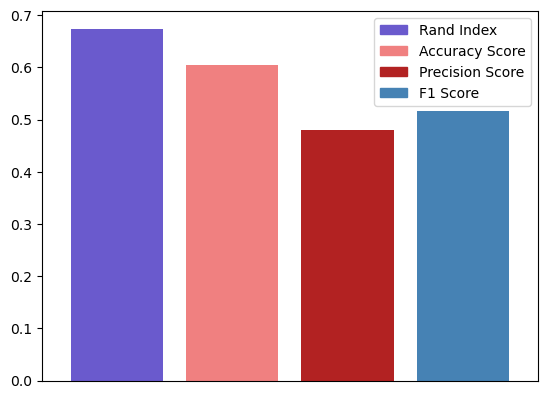

                            TN     FP    FN     TP  accuracy
B                       181598   1587  2031   6848  0.981163
CD3 T                   172768  15481  1420   2395  0.912003
CD4 T                   178429   1853  7352   4430  0.952073
CD8 T                   174277   2589  9515   5683  0.936979
Keratin-positive tumor   47772  46809   534  96949  0.753504
                        precision    recall  f1-score   support
B                        0.811855  0.771258  0.791036    8879.0
CD3 T                    0.133979  0.627785  0.220829    3815.0
CD4 T                    0.705077  0.375997  0.490451   11782.0
CD8 T                    0.687016  0.373931  0.484278   15198.0
Keratin-positive tumor   0.674390  0.994522  0.803752   97483.0
micro avg                0.629956  0.847970  0.722883  137157.0
macro avg                0.602464  0.628699  0.558069  137157.0
weighted avg             0.672293  0.847970  0.724402  137157.0


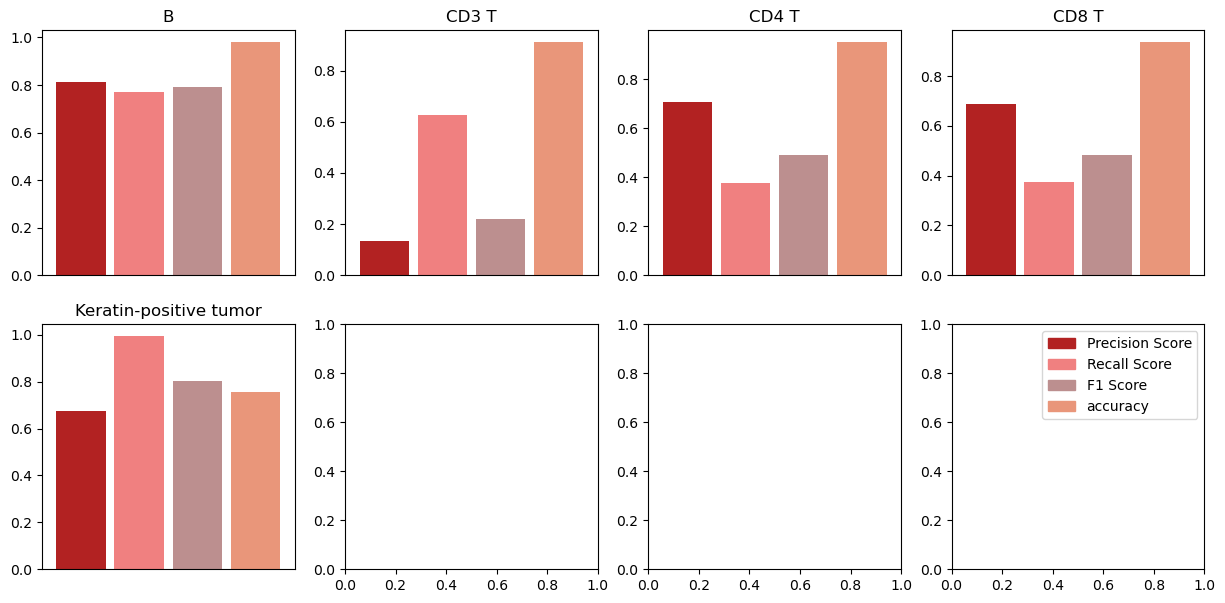

In [23]:
cell_num_compare(labels_true_2, labels_df["Global"])

heatmap_for_median_expression(sample_data, labels_df, logic, level="Global", save=False, fname=None,
                                dpi='figure', transform=z_score, title="{} Marker Expression".format(level),
                                c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                cmap_='vlag', dendrogram_ratio_=0.1)

my_confusion_matrix(labels_true_2, labels_df["Global"])
cluster_metrics_overall(labels_true_2, labels_df["Global"])
cluster_metrics_percelltype(labels_true_2, labels_df["Global"])